# Free-energy / Predictive Coding Tutorial

Solutions to exercises from the paper <a href=https://www.sciencedirect.com/science/article/pii/S0022249615000759>"A tutorial on the free-energy framework for modelling perception and learning"</a> in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-x1c387ma because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Exercise 1: Bayesian inference

In [2]:
def g(x):
    return x**2

def normal_dist(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma)) * np.exp(- ((x - mu)**2) / (2*sigma))

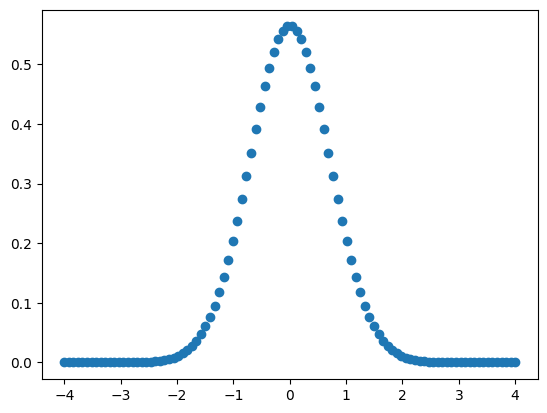

In [3]:
u = np.linspace(-4,4,100)
plt.scatter(u, normal_dist(u,0,0.5))
plt.show()

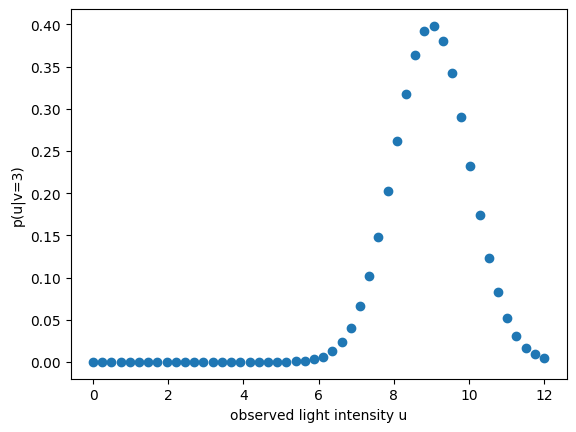

In [4]:
# given a v (object size)
v = 3

# this is the distribution of probabilities of observing different u's given the object size of 3
u = np.linspace(0,12,50)
plt.scatter(u, normal_dist(u, g(v), 1))
plt.xlabel('observed light intensity u')
plt.ylabel('p(u|v=3)')
plt.show()

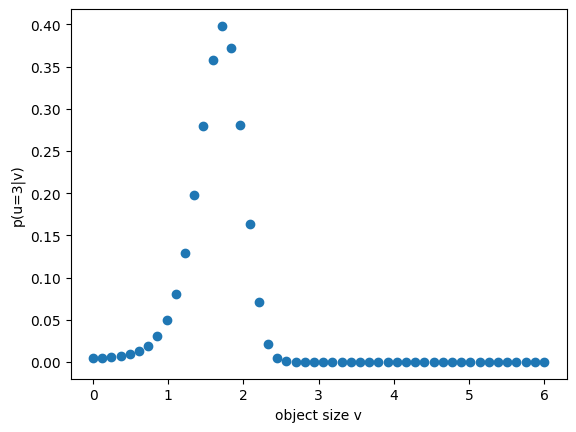

In [5]:
# given an observed intensity u
u = 3

# this is the distribution of probabilities of different object sizes when the observed light intensity is uobserving different u's given the object size of 3
v = np.linspace(0,6,50)
plt.scatter(v, normal_dist(u, g(v), 1))
plt.xlabel('object size v')
plt.ylabel('p(u=3|v)')
plt.show()

$$
Bayes\ theorem\ p(v|u)=\frac{p(v)p(u|v)}{p(u)}
$$
$$
Normalisation\ term\ p(u)=\int p(v)p(u|v)dv
$$

In [6]:
u = 2
sigma_u = 1
v_prior = 3
sigma_prior = 1

# bayesian inference with numpy vectorised operations
v_values = np.linspace(0.01, 5, 100)
prior = normal_dist(v_values, v_prior, sigma_prior)
likelihood = normal_dist(u, g(v_values), sigma_u)
dv = v_values[1] - v_values[0]
normalisation_term = (prior * likelihood * dv).sum()
posterior_v_values = (prior * likelihood) / normalisation_term

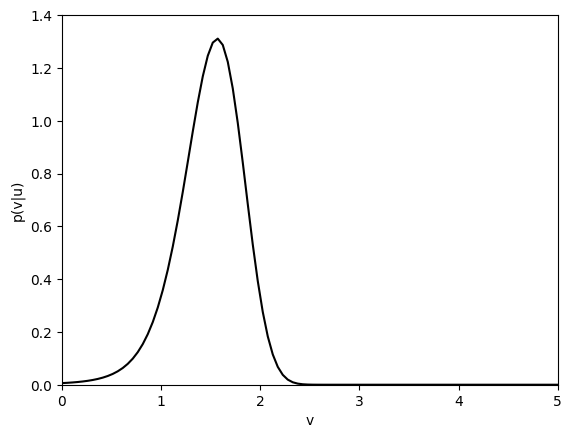

In [7]:
plt.plot(v_values, posterior_v_values, c='black')
plt.xlabel('v')
plt.ylabel('p(v|u)')
plt.xlim([0,5])
plt.ylim([0,1.4])
plt.show()

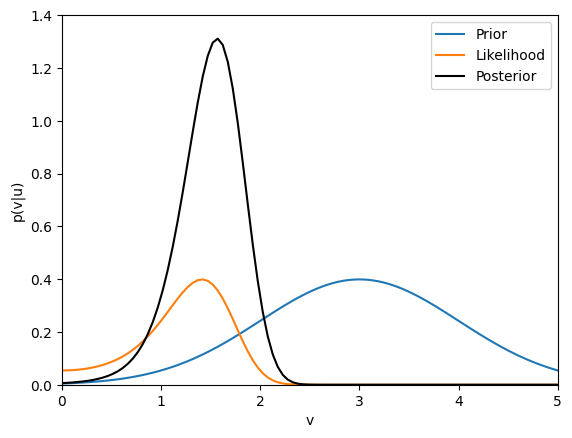

In [8]:
plt.plot(v_values, prior)
plt.plot(v_values, likelihood)
plt.plot(v_values, posterior_v_values, c='black')
plt.xlabel('v')
plt.ylabel('p(v|u)')
plt.xlim([0,5])
plt.ylim([0,1.4])
plt.legend(['Prior','Likelihood','Posterior'])
plt.show()

# Exercise 2: most likely value $\phi$

$$
p(v|u)=\frac{p(v)p(u|v)}{p(u)}
$$
<center>$ \phi $ is the most likely value of v which maximises the posterior</center>
</br>
$$
ln(p(v|u))=F=ln(p(v)p(u|v))
$$
</br>
$$
F=ln(p(v)) + ln(p(u|v))
$$
</br>
$$
F = {1 \over 2}(-ln \Sigma_p - {(\phi - v_p)^2\over \Sigma_p} -ln \Sigma_u - {(u - g(\phi))^2\over \Sigma_u}) + C
$$
</br>
$$
\frac{\delta F}{\delta \phi} = \frac{v_p - \phi}{\Sigma p} + \frac{u - g(\phi)}{\Sigma u}g'(\phi)
$$
</br>
<center>Euler's method: $\phi(t+\Delta t)=\phi(t)+\Delta t \frac{\delta F}{\delta \phi}$</center>
</br>

In [9]:
# Euler method computes the estimate of phi across simulated time - not real temporal dynamics. How does dF/dPhi derivative fit in here conceptually and unit-wise?

In [10]:
def g_der(x):
    return 2*x

def dFdPhi(phi,v_p,sigma_p,u,sigma_u):
    return ((v_p-phi)/sigma_p) + ((u - g(phi))/sigma_u) * g_der(phi)

def euler_iteration(x_old, dt, derivative):
    return x_old + dt * derivative

In [11]:
t = np.linspace(0,5,100)
dt = 0.01

phi_estimates = [v_prior]

for i in range(len(t)-1):
    derivative = dFdPhi(phi_estimates[-1], v_prior, sigma_prior, u, sigma_u)
    phi_estimates.append(euler_iteration(phi_estimates[-1], dt, derivative))

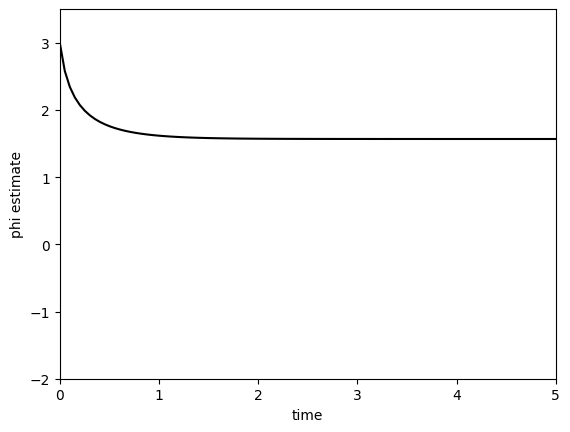

In [12]:
plt.plot(t, phi_estimates, c='black')
plt.xlabel('time')
plt.ylabel('phi estimate')
plt.xlim([0,5])
plt.ylim([-2,3.5])
plt.show()

# Exercise 3: neural implementation with Prediction Error (PE) units

<center><img src=https://ars.els-cdn.com/content/image/1-s2.0-S0022249615000759-gr3.jpg></center>

$$
\epsilon_p' = \phi - v_p - \Sigma_p \epsilon_p
$$
$$
\epsilon_u' = u - g(\phi) - \Sigma_u \epsilon_u
$$

In [13]:
# initialising values
t = np.linspace(0, 5, 1000)
phi_estimates = np.zeros_like(t)
phi_estimates[0] = v_prior
e_p_values = np.zeros_like(t)
e_u_values = np.zeros_like(t)

# Simulating with Euler method and node acitivty differential equations
for i in range(1, len(t)):
    e_p_values[i] = e_p_values[i-1] + dt * (phi_estimates[i-1] - v_prior - sigma_prior * e_p_values[i-1])
    e_u_values[i] = e_u_values[i-1] + dt * (u - g(phi_estimates[i-1]) - sigma_u * e_u_values[i-1])
    phi_estimates[i] = phi_estimates[i-1] + dt * (e_u_values[i-1] * g_der(phi_estimates[i-1]) - e_p_values[i-1])

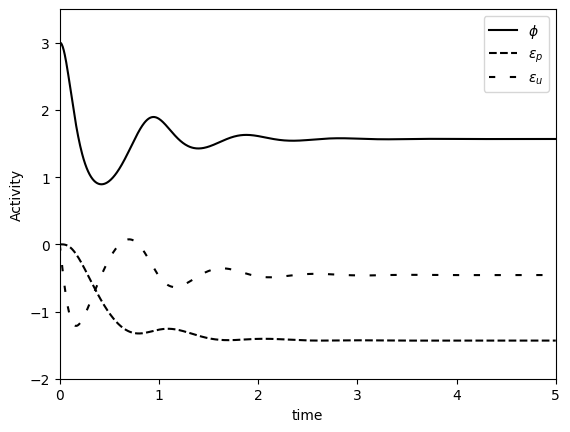

In [14]:
plt.plot(t, phi_estimates, c='black')
plt.plot(t, e_p_values, c='black', linestyle='dashed')
plt.plot(t, e_u_values, c='black', linestyle=(0, (3, 7)))
plt.xlabel('time')
plt.ylabel('Activity')
plt.xlim([0,5])
plt.ylim([-2, 3.5])
plt.legend(['$\phi$', '$\epsilon_p$', '$\epsilon_u$'])
plt.show()

# Exercise 4: derivatives in vector form

$$
y = \bar{x}.T \cdot \bar{x} = x_1^2 + x_2^2
$$
$$
\frac{\delta y}{\delta \bar{x}}=(\frac{\delta y}{\delta x_1}, \frac{\delta y}{\delta x_2}) = (2x_1, 2x_2) = 2\bar{x}
$$

# Exercise 5: network with Prediction Errors and local Hebbian plasticity

$$
\epsilon_i'=\phi_i - g_i(\phi_{i+1})-e_i
$$
$$
e_i'=\Sigma_i\epsilon_i -e_i
$$
$$
\Delta\Sigma_i = \alpha(\epsilon_ie_i - 1)
$$

In [15]:
num_trials = 1000
num_timesteps = 20
alpha = 0.01
g = 5 # g_i(phi_i+1)

sigma_values = [1]

In [16]:
for trial in range(num_trials):
    epsilon_values = [0]
    e_values = [0]
    phi = np.random.normal(loc=5, scale=np.sqrt(2))
    
    for t in range(1,int(num_timesteps/dt)):
        epsilon_derivative = phi - g - e_values[-1]
        epsilon_values.append(epsilon_values[-1] + dt * epsilon_derivative)
        
        e_derivative = sigma_values[-1] * epsilon_values[-1] - e_values[-1]
        e_values.append(e_values[-1] + dt * e_derivative)
    
    change_in_sigma = alpha * (epsilon_values[-1] * e_values[-1] - 1)
    sigma_values.append(sigma_values[-1] + change_in_sigma)

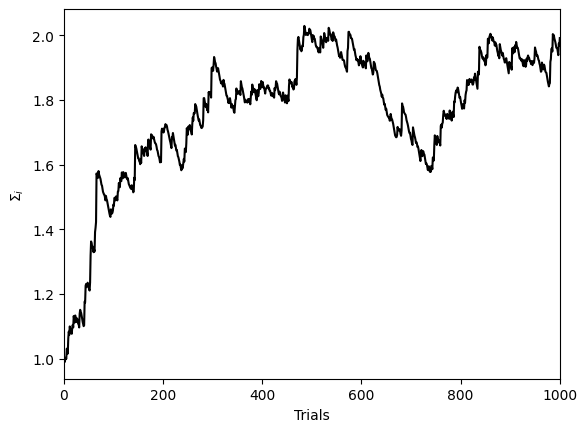

In [17]:
plt.plot(sigma_values, c='black')
plt.xlim([0,1000])
plt.xlabel('Trials')
plt.ylabel('$\Sigma_i$')
plt.show()